# Projet Big Data

Robin Duraz, Jiaxin Gao, Xihui Wang

Nous avons choisi de travailler sur les données du projet Criteo de Kaggle, disponible à https://www.kaggle.com/c/criteo-display-ad-challenge, en utilisant PySpark.

L'ensemble des données étant trop grand pour pouvoir être traité avec nos machines, nous avons réduit la taille des données en ne prenant que le premier million de lignes du fichier de train.
    
    head -n 1000000 nomFichierTrain > small_train.txt

## Sources utilisées

La visualisation plus loin utilisant pandas scatter_matrix vient de :

https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

Pour le reste, nous nous sommes inspirés de :

la documentation de MLlib visible à :

https://spark.apache.org/docs/latest/ml-guide.html

La page https://www.datacamp.com/community/tutorials/apache-spark-tutorial-machine-learning?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t1&utm_creative=255768618198&utm_targetid=aud-299261629574:dsa-473406582395&utm_loc_interest_ms=&utm_loc_physical_ms=9056462&gclid=EAIaIQobChMIzLGz1vL73gIVDOJ3Ch2HsAZPEAAYASAAEgI4V_D_BwE#evaluate

Ainsi que https://docs.databricks.com/spark/latest/mllib/index.html qui possède de nombreux exemples

## Installation utilisée

Considérant Spark bien installé, nous avons utilisé findspark pour ne pas avoir besoin de créer de variables d'environnement. Cette étape n'est pas nécessaire si les variables d'environnement sont utilisées.

Installer findspark avec pip, puis fournir le bon chemin vers le $SPARK_HOME dans

In [1]:
import findspark
findspark.init("/opt/spark-2.3.2-bin-hadoop2.7")

## Chargement des données

In [2]:
from pyspark import SparkContext
from pyspark import SQLContext

#### Paramètres supplémentaires

Les deux paramètres suivants sont changés de leur valeurs de base pour permettre aux DecisionTree & Random Forest de mettre plus de choses dans le cache. Ils ont été finalement enlevés (DecisionTree & RandomForest) car ces paramètres, ainsi que d'autres méthodes essayées, n'étaient pas suffisant pour les utiliser.

Cela permet entre autre de prendre plus de données pour l'entraînement et/ou l'accélérer

In [4]:
SparkContext.setSystemProperty('spark.executor.memory', '4g')
SparkContext.setSystemProperty('spark.driver.memory', '4g')

In [5]:
sc = SparkContext("local").getOrCreate()
sqlContext = SQLContext(sc)

In [6]:
dataset = sc.textFile("small_train.txt")

## Pré-traitement des données

Charger les données récupérées dans des dataframes ayant des noms de colonne, puis faire un cast des colonnes contenant des entiers pour qu'ils aient bien un type Integer

In [7]:
dataset = dataset.map(lambda x : x.split("\t"))

In [8]:
numCols = ["intFeature_{}".format(i) for i in range(1,14)]
catCols = ["catFeature_{}".format(i) for i in range(1,27)]
df = sqlContext.createDataFrame(dataset, ["label"] + numCols + catCols)

In [9]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
for colname in ["label"] + numCols:
    df = df.withColumn(colname, col(colname).cast(IntegerType()))

In [10]:
# Vérification des opérations
df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- intFeature_1: integer (nullable = true)
 |-- intFeature_2: integer (nullable = true)
 |-- intFeature_3: integer (nullable = true)
 |-- intFeature_4: integer (nullable = true)
 |-- intFeature_5: integer (nullable = true)
 |-- intFeature_6: integer (nullable = true)
 |-- intFeature_7: integer (nullable = true)
 |-- intFeature_8: integer (nullable = true)
 |-- intFeature_9: integer (nullable = true)
 |-- intFeature_10: integer (nullable = true)
 |-- intFeature_11: integer (nullable = true)
 |-- intFeature_12: integer (nullable = true)
 |-- intFeature_13: integer (nullable = true)
 |-- catFeature_1: string (nullable = true)
 |-- catFeature_2: string (nullable = true)
 |-- catFeature_3: string (nullable = true)
 |-- catFeature_4: string (nullable = true)
 |-- catFeature_5: string (nullable = true)
 |-- catFeature_6: string (nullable = true)
 |-- catFeature_7: string (nullable = true)
 |-- catFeature_8: string (nullable = true)
 |-- catFeature_

In [11]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0,0,0,0,0
intFeature_1,1,2,2,NaN,3
intFeature_2,1,0,0,893,-1
intFeature_3,5,44,1,NaN,NaN
intFeature_4,0,1,14,NaN,0
intFeature_5,1382,102,767,4392,2
intFeature_6,4,8,89,NaN,0
intFeature_7,15,2,4,0,3
intFeature_8,2,2,2,0,0
intFeature_9,181,4,245,0,0


### Visualisation des valeurs dans les colonnes d'entiers

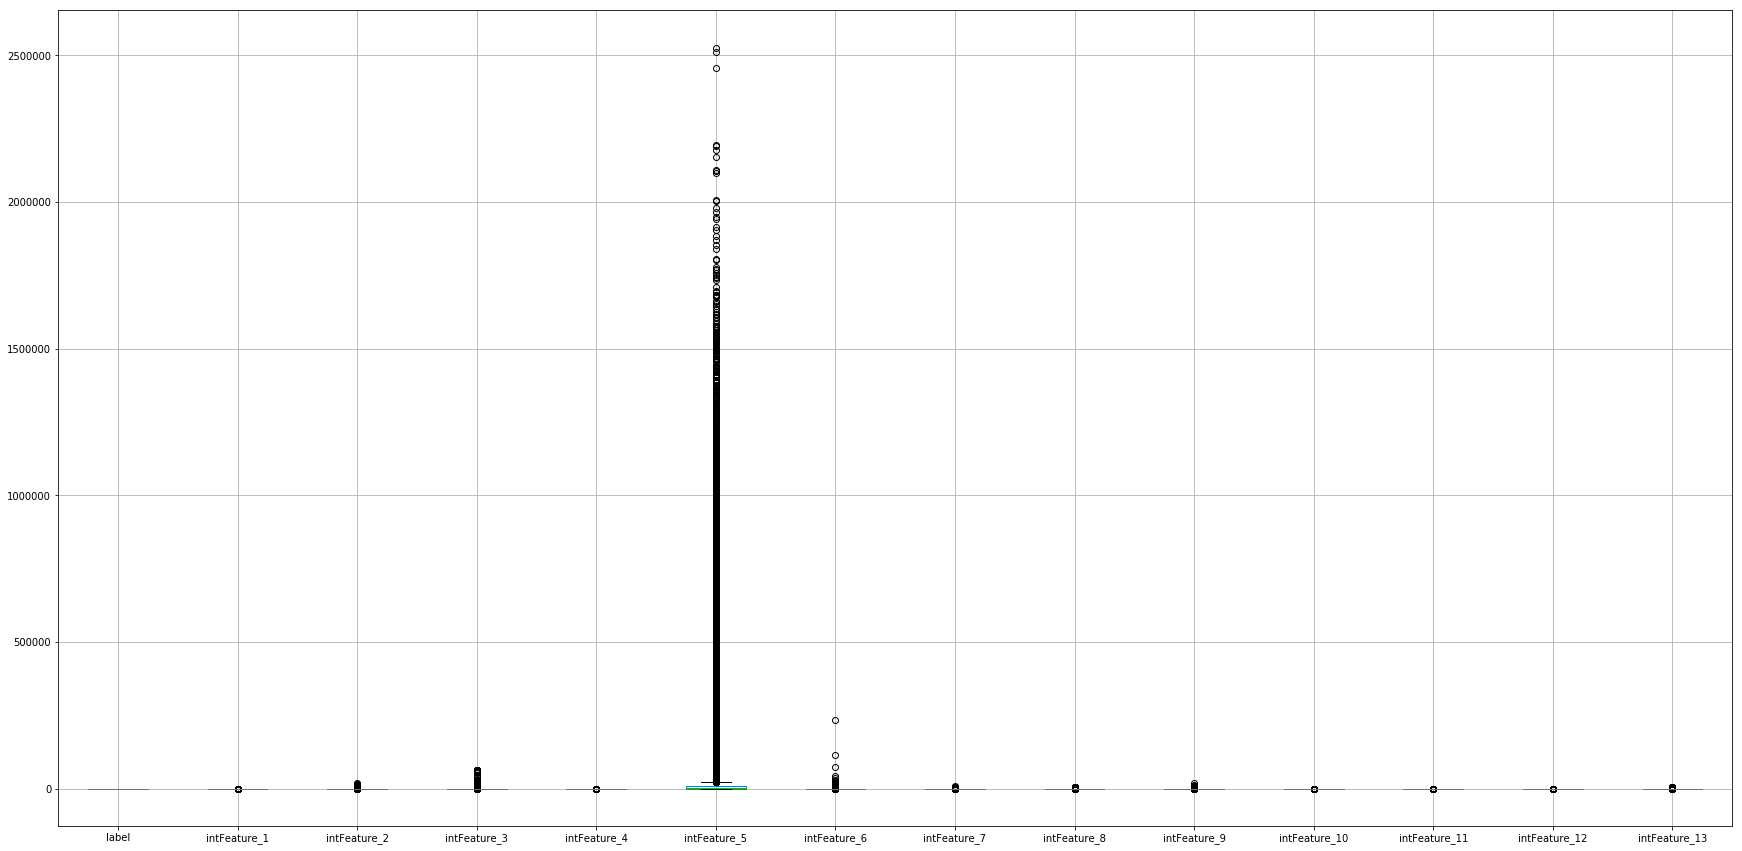

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30,15))
data=df.toPandas()
data.boxplot()
plt.show()

In [13]:
df.toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
label,1000000.0,0.254949,0.435833,0.0,0.0,0.0,1.0,1.0
intFeature_1,576997.0,3.238400,8.944151,0.0,0.0,1.0,3.0,780.0
intFeature_2,1000000.0,93.965184,349.884675,-2.0,0.0,2.0,32.0,18522.0
intFeature_3,764946.0,21.094269,344.010001,0.0,2.0,5.0,14.0,65535.0
intFeature_4,750884.0,6.954270,8.554014,0.0,2.0,4.0,9.0,507.0
intFeature_5,975464.0,18616.531735,67686.651149,0.0,829.0,2548.0,10163.0,2527030.0
intFeature_6,778260.0,116.761653,456.056847,0.0,8.0,33.0,102.0,233523.0
intFeature_7,959166.0,14.592224,58.277459,0.0,1.0,3.0,11.0,8807.0
intFeature_8,999338.0,13.378894,32.345836,0.0,2.0,8.0,20.0,5064.0
intFeature_9,959166.0,105.450931,217.405401,0.0,10.0,39.0,110.0,19327.0


### Répartition des classes

In [14]:
rep = df.groupBy("label").count()
rep.show()

+-----+------+
|label| count|
+-----+------+
|    1|254949|
|    0|745051|
+-----+------+



In [15]:
counts = rep.select("count").collect()
number_0 = counts[1][0]
number_1 = counts[0][0]
print("Répartition des classes :\n 0 : {:2%} \n 1 : {:2%}"
      .format(number_0 / (number_0 + number_1), number_1 / (number_0 + number_1)))

Répartition des classes :
 0 : 74.505100% 
 1 : 25.494900%


### Suppression de lignes

Suppression des lignes ayant un null dans une colonne d'entier, et remplacement des null par NA dans les colonnes catégorielles.

In [16]:
df = df.na.replace("", "na", catCols)

df = df.na.drop()

In [17]:
df.toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
label,118604.0,0.299172,0.457897,0.0,0.0,0.0,1.0,1.0
intFeature_1,118604.0,5.284063,12.771607,0.0,0.0,1.0,5.0,780.0
intFeature_2,118604.0,92.424075,332.011876,-2.0,1.0,5.0,39.0,7278.0
intFeature_3,118604.0,16.715954,107.310304,0.0,2.0,6.0,15.0,19057.0
intFeature_4,118604.0,8.770269,9.622896,0.0,2.0,6.0,12.0,417.0
intFeature_5,118604.0,1799.595275,3675.804453,0.0,43.0,972.0,2191.0,157880.0
intFeature_6,118604.0,87.319095,256.461947,0.0,7.0,26.0,80.0,20026.0
intFeature_7,118604.0,44.201199,124.572995,0.0,5.0,14.0,38.0,8807.0
intFeature_8,118604.0,20.752470,14.472857,0.0,8.0,18.0,32.0,57.0
intFeature_9,118604.0,218.042587,341.553557,0.0,34.0,102.0,266.0,12661.0


### Nouvelle visualisation des colonnes d'entiers

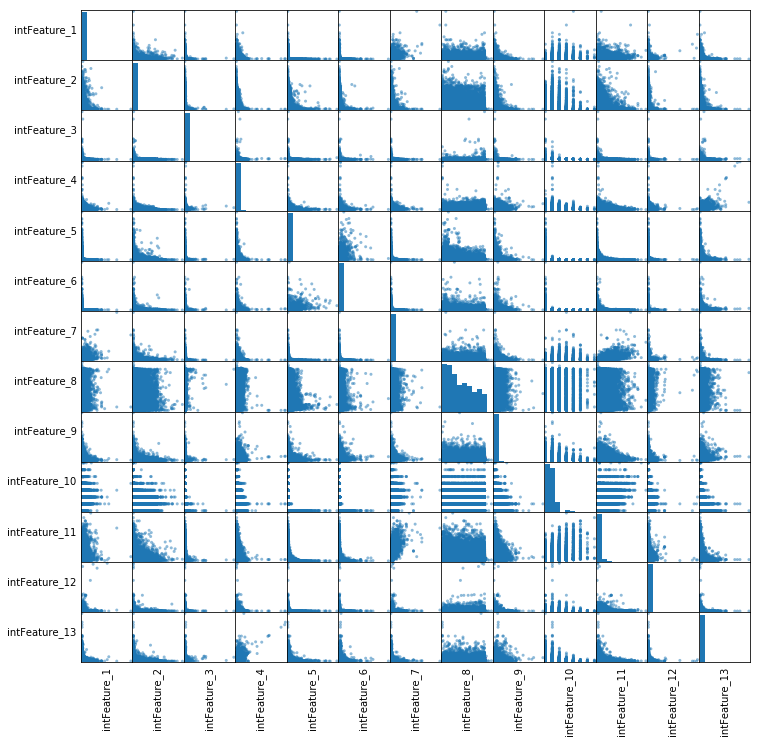

In [18]:
%matplotlib inline

numdata = df.select(numCols).toPandas()

axs = pd.plotting.scatter_matrix(numdata, figsize=(12, 12));

n = len(numdata.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

#### Que faire de intFeature_10 ?

intFeature_10 semble avoir une corrélation avec toutes les autres features entières, et il pourrait être intéressant d'essayer de l'enlever, ou bien de ne garder qu'elle, et voir si les résultats varient.

### Nouvelle répartition des classes

In [19]:
rep = df.groupBy("label").count()
rep.show()

+-----+-----+
|label|count|
+-----+-----+
|    1|35483|
|    0|83121|
+-----+-----+



In [20]:
counts = rep.select("count").collect()
number_0 = counts[1][0]
number_1 = counts[0][0]
print("Répartition des classes :\n 0 : {:2%} \n 1 : {:2%}"
      .format(number_0 / (number_0 + number_1), number_1 / (number_0 + number_1)))

Répartition des classes :
 0 : 70.082797% 
 1 : 29.917203%


## Transformation des features

Nous avons vu dans la documentation de MLlib que les algorithmes de classification préféraient avoir des valeurs encodées quand il s'agissait de colonnes catégorielles. C'est donc ce que nous avons fait

In [21]:
from pyspark.ml import Pipeline

### String indexing + OneHotEncoding des categorical features pour les données

In [22]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer

stages = []

for categoricalCol in catCols:
    strIdx = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + "_Idx")
    oneHot = OneHotEncoderEstimator(inputCols = [strIdx.getOutputCol()], outputCols = ["oneHot_" + categoricalCol])
    stages += [strIdx, oneHot]

### Assemblage des features gardées dans un vecteur de features

In [23]:
from pyspark.ml.feature import VectorAssembler

assemblerInputs = numCols + ["oneHot_" + c for c in catCols]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [24]:
pipe = Pipeline().setStages(stages)
pipeModel = pipe.fit(df)
pp_df = pipeModel.transform(df)

#### Vérification des opération avec le schéma

In [25]:
pp_df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- intFeature_1: integer (nullable = true)
 |-- intFeature_2: integer (nullable = true)
 |-- intFeature_3: integer (nullable = true)
 |-- intFeature_4: integer (nullable = true)
 |-- intFeature_5: integer (nullable = true)
 |-- intFeature_6: integer (nullable = true)
 |-- intFeature_7: integer (nullable = true)
 |-- intFeature_8: integer (nullable = true)
 |-- intFeature_9: integer (nullable = true)
 |-- intFeature_10: integer (nullable = true)
 |-- intFeature_11: integer (nullable = true)
 |-- intFeature_12: integer (nullable = true)
 |-- intFeature_13: integer (nullable = true)
 |-- catFeature_1: string (nullable = true)
 |-- catFeature_2: string (nullable = true)
 |-- catFeature_3: string (nullable = true)
 |-- catFeature_4: string (nullable = true)
 |-- catFeature_5: string (nullable = true)
 |-- catFeature_6: string (nullable = true)
 |-- catFeature_7: string (nullable = true)
 |-- catFeature_8: string (nullable = true)
 |-- catFeature_

In [26]:
select_cols = ["label"] + ["features"]
pp_df = pp_df.select(select_cols)
train, test = pp_df.randomSplit([0.7, 0.3])
train.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



In [27]:
pd.DataFrame(train.select("features", "label").take(5), columns=["features","label"])

,features,label
0,"(4.0, 4.0, 6.0, 8.0, 8.0, 9.0, 4.0, 7.0, 8.0, ...",0
1,"(1.0, 119.0, 3.0, 11.0, 560.0, 23.0, 26.0, 24....",0
2,"(1.0, 417.0, 17.0, 8.0, 764.0, 146.0, 24.0, 29...",0
3,"(1.0, 1.0, 8.0, 6.0, 813.0, 17.0, 1.0, 10.0, 1...",0
4,"(12.0, 4.0, 1.0, 1.0, 846.0, 1.0, 13.0, 23.0, ...",0


## ML algorithmes

### Fonctions utiles à l'évaluation des modèles

In [28]:
## Log loss de sklearn pour évaluer les modèles
from sklearn.metrics import log_loss

def logloss(y_true, y_proba):
    y_true = [y.__getitem__("label") for y in y_true]
    y_proba = [y.__getitem__("probability") for y in y_proba]
    y_proba = [[i for i in j] for j in y_proba]
    return log_loss(y_true, y_proba)

def logloss_pred(y_true, y_pred):
    y_true = [y.__getitem__("label") for y in y_true]
    y_proba = [y.__getitem__("prediction") for y in y_pred]
    y_proba = [[0.0, 1.0] if j else [1.0, 0.0] for j in y_proba]
    return log_loss(y_true, y_proba)

def accuracy(y_true, y_pred):
    y_true = [y.__getitem__("label") for y in y_true]
    y_pred = [y.__getitem__("prediction") for y in y_pred]
    egal = [y_true[i] == y_pred[i] for i in range(len(y_true))]
    return sum(egal)/len(y_true)

In [29]:
y_true = test.select("label").collect()

### Régression logistique

In [30]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(maxIter=5, threshold=0.3)

# Train model with Training Data
lrModel = lr.fit(train)

#### Evaluation du modèle

##### Sur le train

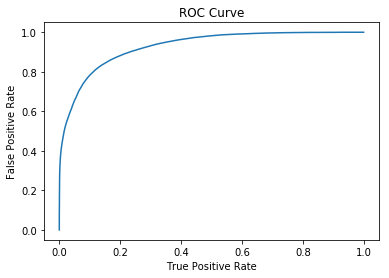

Training set areaUnderROC: 0.927642156032551


In [31]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

##### Sur le test

In [32]:
predictions = lrModel.transform(test)

y_proba = predictions.select("probability").collect()
y_pred = predictions.select("prediction").collect()

In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluateur proposé par Spark pour la classification binaire
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Aire sous la courbe ROC ")
evaluator.evaluate(predictions)

Aire sous la courbe ROC 


0.7039124171645159

In [39]:
ll = logloss(y_true, y_proba)
acc = accuracy(y_true, y_pred)
print("Log loss = {:2f},\nLog loss divisée par le nombre d'exemples = {:2f},\nAccuracy = {:2%}"
      .format(ll, ll / len(y_true), acc))

Log loss = 0.582487,
Log loss divisée par le nombre d'exemples = 0.000016,
Accuracy = 67.906623%


##### Comparaison avec prédire que des 0 (classe majoritaire)

In [35]:
# If we predict all 0
from pyspark.sql.functions import lit
predictions0 = predictions.withColumn("prediction", lit(0.0))
predictions0.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [36]:
pred_0 = predictions.select("prediction").collect()

In [40]:
ll = logloss_pred(y_true, pred_0)
acc = accuracy(y_true, pred_0)
print("Log loss = {:2f},\nLog loss divisée par le nombre d'exemples = {:2f},\nAccuracy = {:2%}"
      .format(ll, ll / len(y_true), acc))

Log loss = 11.084660,
Log loss divisée par le nombre d'exemples = 0.000312,
Accuracy = 67.906623%


Bien que les valeurs d'accuracy soient similaires, la log loss est bien plus faible pour les prédictions du modèles.

On voit donc, que même s'il finit par prédire la même chose, ses prédictions sont dans l'ensemble bien plus proches des bonnes prédictions.

### SVM

In [41]:
from pyspark.ml.classification import LinearSVC

svc = LinearSVC(maxIter=10, regParam=0.1)

svcModel = svc.fit(train)

In [42]:
predictions = svcModel.transform(test)

y_pred = predictions.select("prediction").collect()

In [43]:
evaluator.evaluate(predictions)

0.6618905750716337

In [44]:
ll = logloss_pred(y_true, y_pred)
acc = accuracy(y_true, y_pred)
print("Log loss = {:2f},\nLog loss divisée par le nombre d'exemples = {:2f},\nAccuracy = {:2%}"
      .format(ll, ll / len(y_true), acc))

Log loss = 9.731781,
Log loss divisée par le nombre d'exemples = 0.000274,
Accuracy = 71.823609%


L'accuracy est un peu meilleure que pour la régression logistique, mais la loss est bien pire, étant donné que le SVM ne donne pas de probabilités.